## Setup

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import csv
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, GlobalAveragePooling1D, Dense
import numpy as np
import pandas as pd

2023-01-11 18:07:41.532810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
HF_DATASET = 'EvaKlimentova/knots_AF'
MODEL = '/home/jovyan/models/2023_data_v1/cnn_10epochs_94.h5'
OUTPUT = '/home/jovyan/data/new_preds_all_data.csv'
PATCH_SIZES = [10, 20, 30, 50, 80, 150, 200]

## Load data:

In [3]:
from datasets import load_dataset

dataset = load_dataset(HF_DATASET)
dataset

Using custom data configuration EvaKlimentova--knots_AF-cd42605bc53e4fb3
Reusing dataset parquet (/home/jovyan/.cache/huggingface/datasets/EvaKlimentova___parquet/EvaKlimentova--knots_AF-cd42605bc53e4fb3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'latestVersion', 'globalMetricValue', 'uniprotStart', 'uniprotEnd', 'uniprotSequence', 'Length', 'Domain_architecture', 'InterPro', 'Max_Topology', 'Max Freq', 'Knot Core', 'label', 'FamilyName'],
        num_rows: 159028
    })
    test: Dataset({
        features: ['ID', 'latestVersion', 'globalMetricValue', 'uniprotStart', 'uniprotEnd', 'uniprotSequence', 'Length', 'Domain_architecture', 'InterPro', 'Max_Topology', 'Max Freq', 'Knot Core', 'label', 'FamilyName'],
        num_rows: 39758
    })
})

In [4]:
dataset_test = dataset['test'].to_pandas()
dataset_test

,ID,latestVersion,globalMetricValue,uniprotStart,uniprotEnd,uniprotSequence,Length,Domain_architecture,InterPro,Max_Topology,Max Freq,Knot Core,label,FamilyName
0,A0A3S4KGE1,4,71.88,1,123,MQKKIQQWQKIAIAACEQSGRNVVPEIRPAMQLEAWCAEQDSGLKL...,123.0,PF04452;,IPR029028;IPR006700;IPR046886;IPR029026;,3_1,0.880,"(47, 92)",1,SPOUT
1,Q2GXK7,4,80.69,1,339,MSGGWNTIESDALQGVFTYLLDNLGVKDVQFEELLSLDPDALAQLY...,339.0,PF01088;PF18031;,IPR038765;IPR001578;IPR036959;IPR017390;IPR041...,5_2,0.736,"(6, 242)",1,UCH
2,A0A2N2PCU9,4,88.81,1,434,MEWASRVGLPTIQLTFCSNLEVAMVEKFSFEMHFDADMIAREVPSQ...,434.0,PF00092;,IPR002035;IPR036465;,None,NaN,None,0,VIT
3,A0A2E8VC54,4,81.50,1,179,MIEDIFFKDPIFLWLFLFFPIIILWYFFTKNKSQPLLKISSTKGFE...,179.0,PF07584;PF13519;,IPR024163;IPR002035;IPR036465;,None,NaN,None,0,VIT
4,A0A3A3DDF1,4,96.56,1,156,MKIQLVAVGTKMPAWVETGFKEYQRRFPKDMALELLEIPAGKRGKN...,156.0,PF02590;,IPR029028;IPR003742;IPR029026;,3_1,0.732,"(72, 121)",1,SPOUT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39753,A0A316H2N2,4,70.62,1,633,MLDFLELEETVGRAWHRLIGHVQTWPRHPEHAVRLAEVQPVLAVCF...,633.0,PF00092;,IPR002035;IPR036465;,None,NaN,None,0,VIT
39754,A0A2D6PHG0,4,90.06,1,308,MLENILIFVVAVAVLVKSANVTINSLTNLAKNINVSEFLIATVLMG...,308.0,PF01699;,IPR004481;IPR004837;IPR044880;,3_1,0.714,"(50, 244)",1,membrane
39755,A0A7X6TLA9,4,73.31,1,372,MNQNNRHSDNNRNNQSNKRRSSSQSGRSGQQKRQSKFEGGPQDGVL...,372.0,PF00588;PF08032;,IPR029028;IPR029064;IPR004441;IPR001537;IPR013...,3_1,0.958,"(272, 313)",1,SPOUT
39756,J5QJ94,4,82.44,1,344,MEDGWCLTESDPQVFSELLRQLGVKGLQVDDLYSLDAETLAPLQPI...,344.0,PF01088;PF18031;,IPR038765;IPR001578;IPR036959;IPR017390;IPR041...,5_2,0.672,"(6, 251)",1,UCH


In [5]:
dataset_test['label'] = dataset_test['label'].astype(float)
dataset_test['FamilyName'] = dataset_test['FamilyName'].astype('str') 

In [6]:
# smaller sample for development of the visualizations: 
# dataset_test = dataset_test.sample(15000)

In [7]:
dataset_test_sequences = dataset_test['uniprotSequence'].to_list()
len(dataset_test_sequences)

39758

## Load model:

In [8]:
model = tf.keras.models.load_model(MODEL)

2023-01-11 18:07:49.951237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 18:07:50.349877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20783 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:61:00.0, compute capability: 8.6


## Predict:

In [9]:
nucleo_dic = {
    'A': 0,
    'R': 1,
    'N': 2,
    'D': 3,
    'C': 4,
    'Q': 5,
    'E': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'L': 10,
    'K': 11,
    'M': 12,
    'F': 13,
    'P': 14,
    'S': 15,
    'T': 16,
    'W': 17,
    'Y': 18,
    'V': 19,
    'X': 20
}

In [10]:
def create_generator(list_of_arrays):
    for i in list_of_arrays:
        yield i

In [11]:
def encode_sequence(seq):
    seq_onehot = tf.one_hot([nucleo_dic[c] for c in seq], depth=21)
    return np.expand_dims(seq_onehot, axis=0)

In [12]:
def predict_batch(data, start, end):
    encoded_sequences = [encode_sequence(_) for _ in dataset_test_sequences[start:end]]
    dataset = tf.data.Dataset.from_generator(lambda: create_generator(encoded_sequences), output_types= tf.float32)
    predictions = model.predict(dataset, verbose=0)
    predictions = [_[0] for _ in predictions.tolist()]
    del(encoded_sequences)
    return predictions

In [13]:
all_preds = []
step = 10000

for i in range(0, len(dataset_test_sequences), step):
    if i + step > len(dataset_test_sequences):
        end = len(dataset_test_sequences)
    else:
        end = i + step
        
    try:
        all_preds += predict_batch(dataset_test_sequences, i, end)
        print(f'Calculated for data in range {i} - {end}.')
    except Exception:
        print(i)
        print(dataset_test_sequences[i])
        print('ERROR')
    
len(all_preds)

2023-01-11 18:07:54.781207: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-01-11 18:07:55.654206: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-11 18:07:55.655374: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-11 18:07:55.655391: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-11 18:07:55.656701: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-11 18:07:55.656749: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Calculated for data in range 0 - 10000.
Calculated for data in range 10000 - 20000.
Calculated for data in range 20000 - 30000.
Calculated for data in range 30000 - 39758.


39758

In [14]:
dataset_test['pred'] = all_preds
dataset_test

,ID,latestVersion,globalMetricValue,uniprotStart,uniprotEnd,uniprotSequence,Length,Domain_architecture,InterPro,Max_Topology,Max Freq,Knot Core,label,FamilyName,pred
0,A0A3S4KGE1,4,71.88,1,123,MQKKIQQWQKIAIAACEQSGRNVVPEIRPAMQLEAWCAEQDSGLKL...,123.0,PF04452;,IPR029028;IPR006700;IPR046886;IPR029026;,3_1,0.880,"(47, 92)",1.0,SPOUT,1.000000e+00
1,Q2GXK7,4,80.69,1,339,MSGGWNTIESDALQGVFTYLLDNLGVKDVQFEELLSLDPDALAQLY...,339.0,PF01088;PF18031;,IPR038765;IPR001578;IPR036959;IPR017390;IPR041...,5_2,0.736,"(6, 242)",1.0,UCH,9.999423e-01
2,A0A2N2PCU9,4,88.81,1,434,MEWASRVGLPTIQLTFCSNLEVAMVEKFSFEMHFDADMIAREVPSQ...,434.0,PF00092;,IPR002035;IPR036465;,None,NaN,None,0.0,VIT,8.743886e-05
3,A0A2E8VC54,4,81.50,1,179,MIEDIFFKDPIFLWLFLFFPIIILWYFFTKNKSQPLLKISSTKGFE...,179.0,PF07584;PF13519;,IPR024163;IPR002035;IPR036465;,None,NaN,None,0.0,VIT,5.742320e-16
4,A0A3A3DDF1,4,96.56,1,156,MKIQLVAVGTKMPAWVETGFKEYQRRFPKDMALELLEIPAGKRGKN...,156.0,PF02590;,IPR029028;IPR003742;IPR029026;,3_1,0.732,"(72, 121)",1.0,SPOUT,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39753,A0A316H2N2,4,70.62,1,633,MLDFLELEETVGRAWHRLIGHVQTWPRHPEHAVRLAEVQPVLAVCF...,633.0,PF00092;,IPR002035;IPR036465;,None,NaN,None,0.0,VIT,7.222412e-01
39754,A0A2D6PHG0,4,90.06,1,308,MLENILIFVVAVAVLVKSANVTINSLTNLAKNINVSEFLIATVLMG...,308.0,PF01699;,IPR004481;IPR004837;IPR044880;,3_1,0.714,"(50, 244)",1.0,membrane,9.971162e-01
39755,A0A7X6TLA9,4,73.31,1,372,MNQNNRHSDNNRNNQSNKRRSSSQSGRSGQQKRQSKFEGGPQDGVL...,372.0,PF00588;PF08032;,IPR029028;IPR029064;IPR004441;IPR001537;IPR013...,3_1,0.958,"(272, 313)",1.0,SPOUT,9.999236e-01
39756,J5QJ94,4,82.44,1,344,MEDGWCLTESDPQVFSELLRQLGVKGLQVDDLYSLDAETLAPLQPI...,344.0,PF01088;PF18031;,IPR038765;IPR001578;IPR036959;IPR017390;IPR041...,5_2,0.672,"(6, 251)",1.0,UCH,9.989898e-01


In [15]:
dataset_test.to_csv(OUTPUT, encoding='utf-8', index=False)

In [16]:
# dataset_test = pd.read_csv(OUTPUT)

## Summarize & visualize results:

In [17]:
dataset_test['label'].value_counts()

1.0    19932
0.0    19826
Name: label, dtype: int64

In [18]:
dataset_test.loc[dataset_test['label'] == 0.0]

,ID,latestVersion,globalMetricValue,uniprotStart,uniprotEnd,uniprotSequence,Length,Domain_architecture,InterPro,Max_Topology,Max Freq,Knot Core,label,FamilyName,pred
2,A0A2N2PCU9,4,88.81,1,434,MEWASRVGLPTIQLTFCSNLEVAMVEKFSFEMHFDADMIAREVPSQ...,434.0,PF00092;,IPR002035;IPR036465;,None,NaN,None,0.0,VIT,8.743886e-05
3,A0A2E8VC54,4,81.50,1,179,MIEDIFFKDPIFLWLFLFFPIIILWYFFTKNKSQPLLKISSTKGFE...,179.0,PF07584;PF13519;,IPR024163;IPR002035;IPR036465;,None,NaN,None,0.0,VIT,5.742320e-16
10,A0A7C3Z228,4,95.62,1,275,SLHRQGQLHLPLKGKTLAMIFDKPSTRTRVSFEAGMAQLGGTSLYL...,275.0,PF00185;PF02729;,IPR006132;IPR006130;IPR036901;IPR006131;IPR002...,None,NaN,None,0.0,ATCase/OTCase,6.201029e-07
12,A0A7V1FUR4,4,88.31,1,147,MAWPLVIAGMFFAVALILIKSPSPMLIAVGMYLPFQTTFAIFIGGI...,147.0,PF03169;,IPR004813;,None,NaN,None,0.0,membrane,9.959028e-01
13,A0A6B0SWH4,4,90.38,1,312,MRHDHLLSAGQLTREDIEAVLDRAADLADDPGAVGERHADRLLALC...,312.0,PF00185;PF02729;,IPR006132;IPR006130;IPR036901;IPR002082;IPR006...,None,NaN,None,0.0,ATCase/OTCase,2.264165e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39741,A0A239MJA3,4,90.81,1,424,MAGEFRAETFQNEFLPAGTGEVHAIMTVTAGESTDSGGSGGQRLFG...,424.0,PF13768;PF18571;,IPR041176;IPR002035;IPR036465;,None,NaN,None,0.0,VIT,8.408610e-06
39742,A0A7T1MNP6,4,95.06,1,317,MAAINPDPALIQLQGLDLLSSADLSADQTRALLQLAADLKARRLEI...,317.0,PF00185;PF02729;,IPR006132;IPR006130;IPR036901;IPR006131;IPR002...,None,NaN,None,0.0,ATCase/OTCase,3.626294e-04
39746,A0A1G2LSH4,4,79.81,1,261,MKKIILLPIFALAVSLAVWGCDSPPTQSTNSGSVDSNGKLSGQFQD...,261.0,PF00092;,IPR002035;IPR036465;,None,NaN,None,0.0,VIT,4.511216e-12
39752,A0A2V2AY02,4,86.88,1,541,MSAARGRGPRRRAWIGFALAGLMAATGCTADGPAEPTRSRYEEGHL...,541.0,PF13519;,IPR002035;IPR036465;,None,NaN,None,0.0,VIT,1.952101e-01


In [19]:
from sklearn.metrics import confusion_matrix

# just to be sure:
confusion_matrix(dataset_test['label'], dataset_test['pred'].round(), labels=[1, 0])

array([[16436,  3496],
       [ 3535, 16291]])

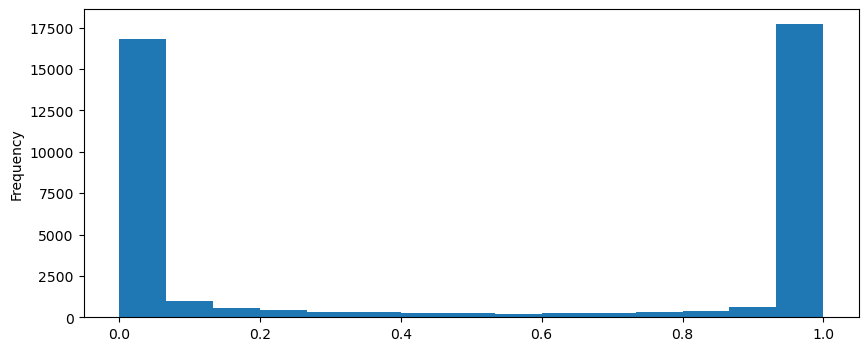

In [20]:
ax = dataset_test['pred'].plot.hist(bins=15, figsize=(10, 4))

Visualize results w.r.t. family:

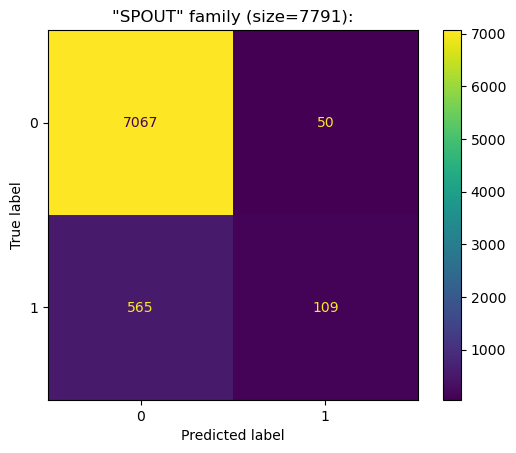

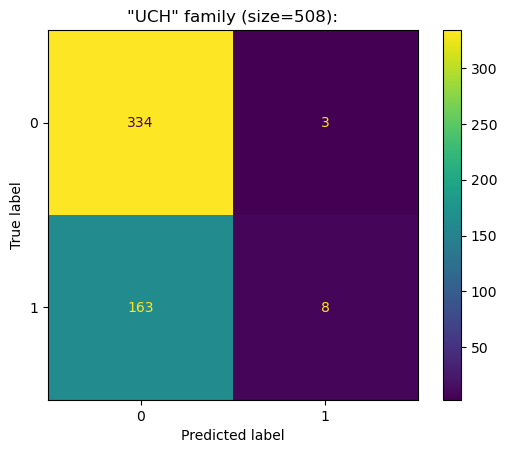

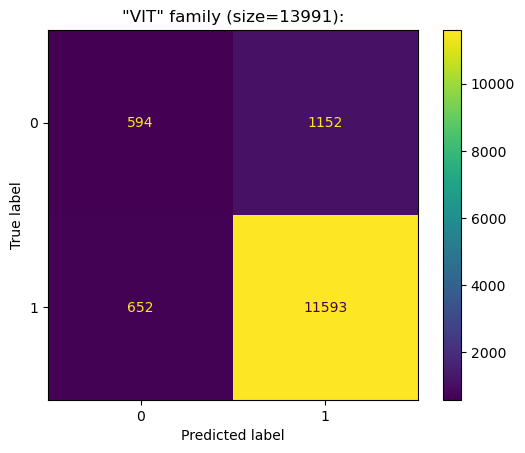

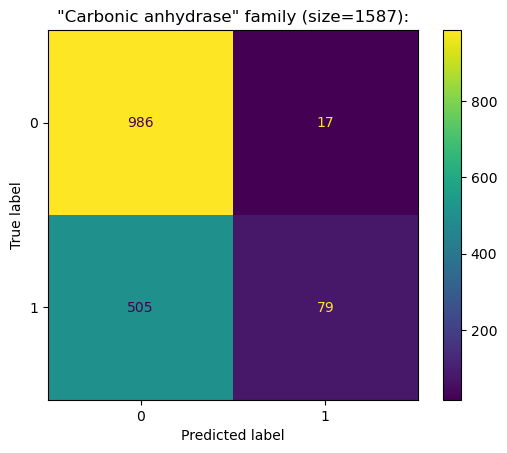

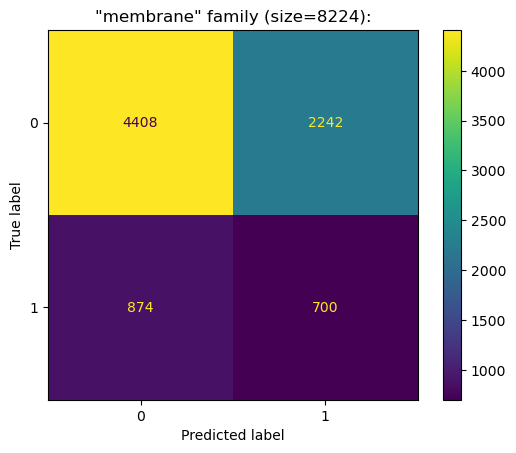

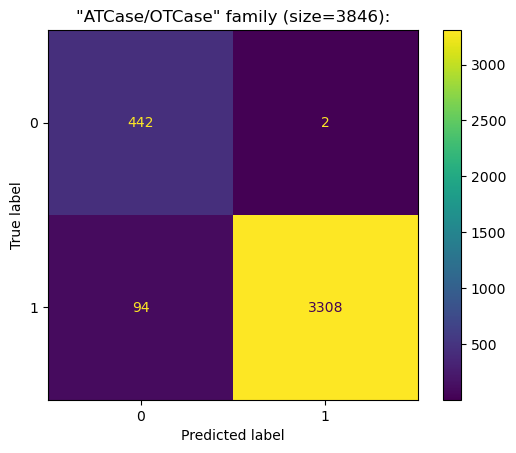

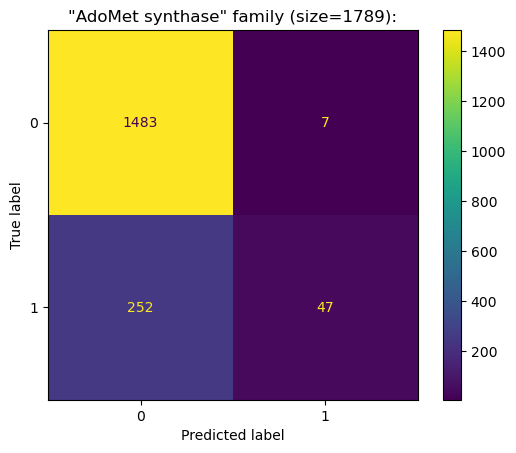

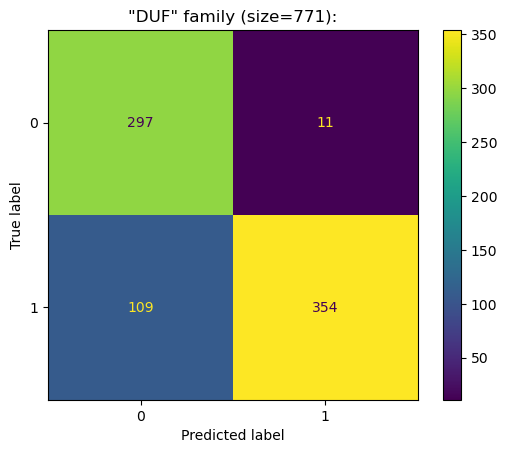

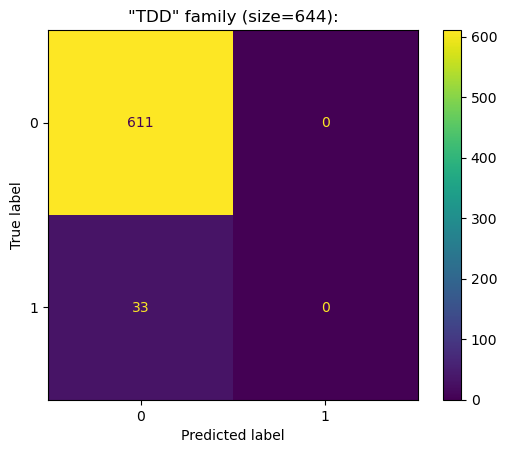

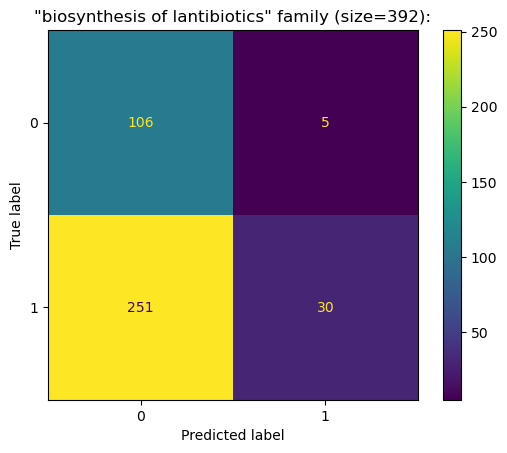

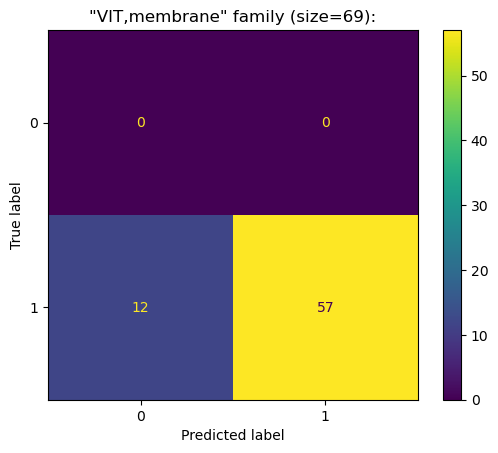

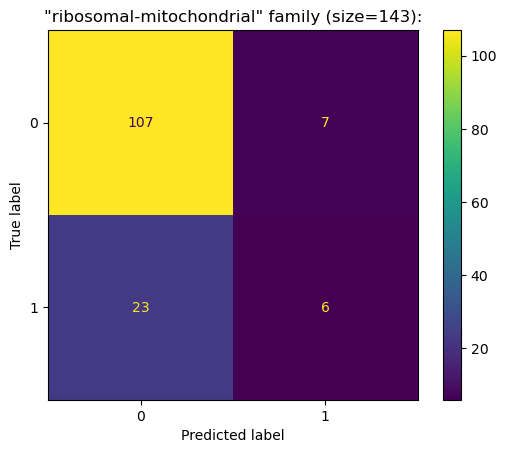

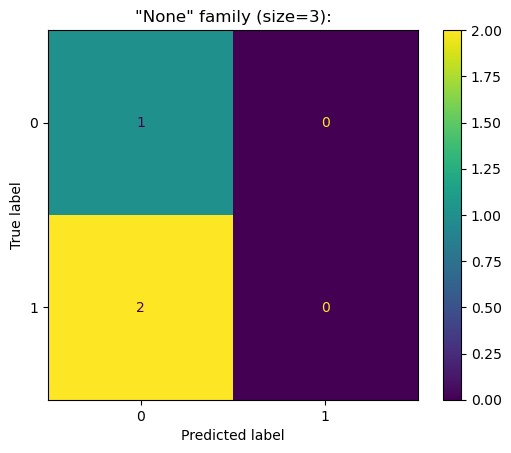

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay


def visualize_family_conf_matrix(df, family_name):
    df_tmp = df.loc[df['FamilyName'] == family_name]
    family_size = len(df_tmp)
    cm = confusion_matrix(df_tmp['label'], df_tmp['pred'].round(), labels=[1, 0])
    cmd = ConfusionMatrixDisplay(cm)
    ax = cmd.plot()
    ax.ax_.set_title(f'"{family_name}" family (size={family_size}):')
    del(df_tmp)

    
families = list(dataset_test['FamilyName'].unique())

for family in families:
    visualize_family_conf_matrix(dataset_test, family)

Check uncertainty of families (it would be nice if all the families had only peaks close to 0.0 and 1.0, not around 0.5):

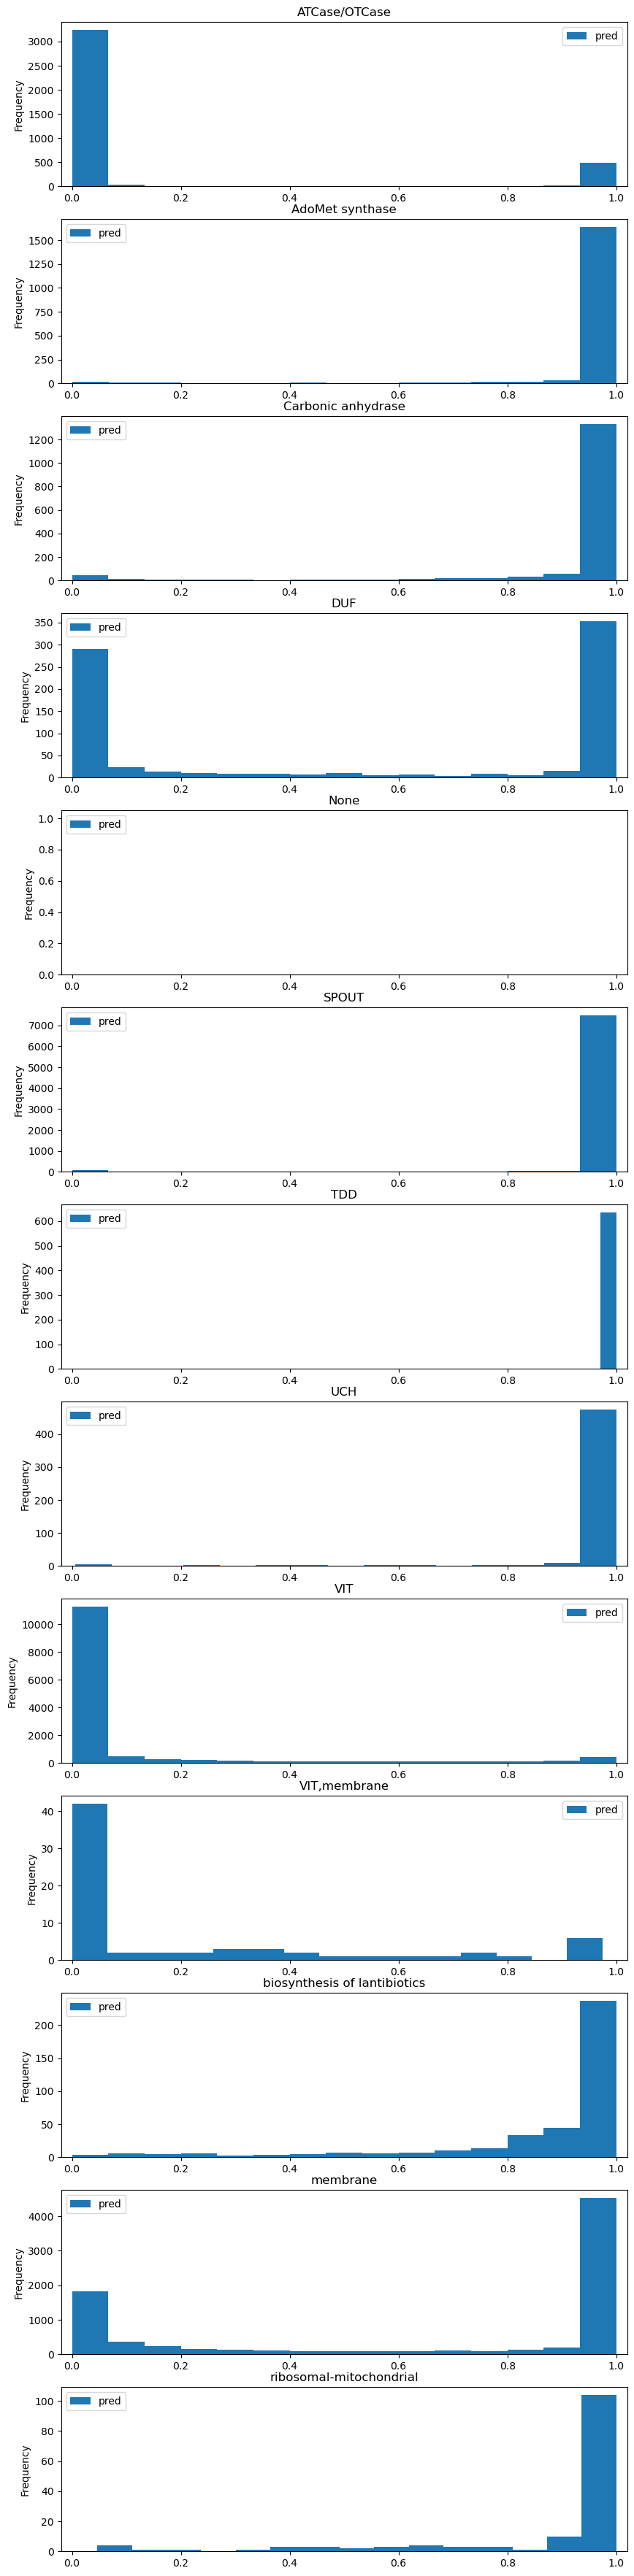

In [22]:
ax = dataset_test.plot.hist(column=['pred'], by='FamilyName', bins=15, figsize=(10, 45), xlim=(-0.02,1.02))